[['VP0-0', 'VP0-1', 'VP0-2'], ['VP1-0', 'VP1-1', 'VP1-2'], ['VP2-0', 'VP2-1', 'VP2-2'], ['VP3-0', 'VP3-1', 'VP3-2']]


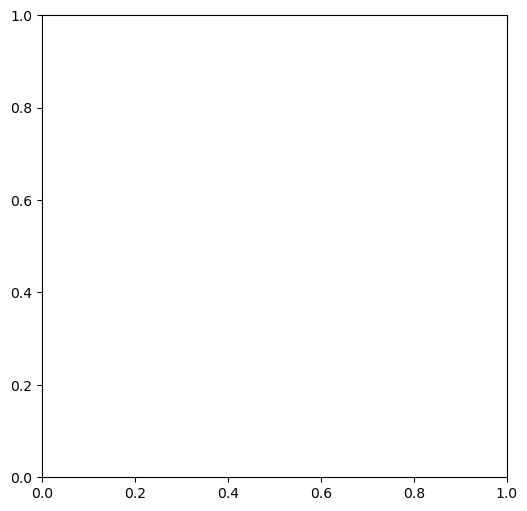

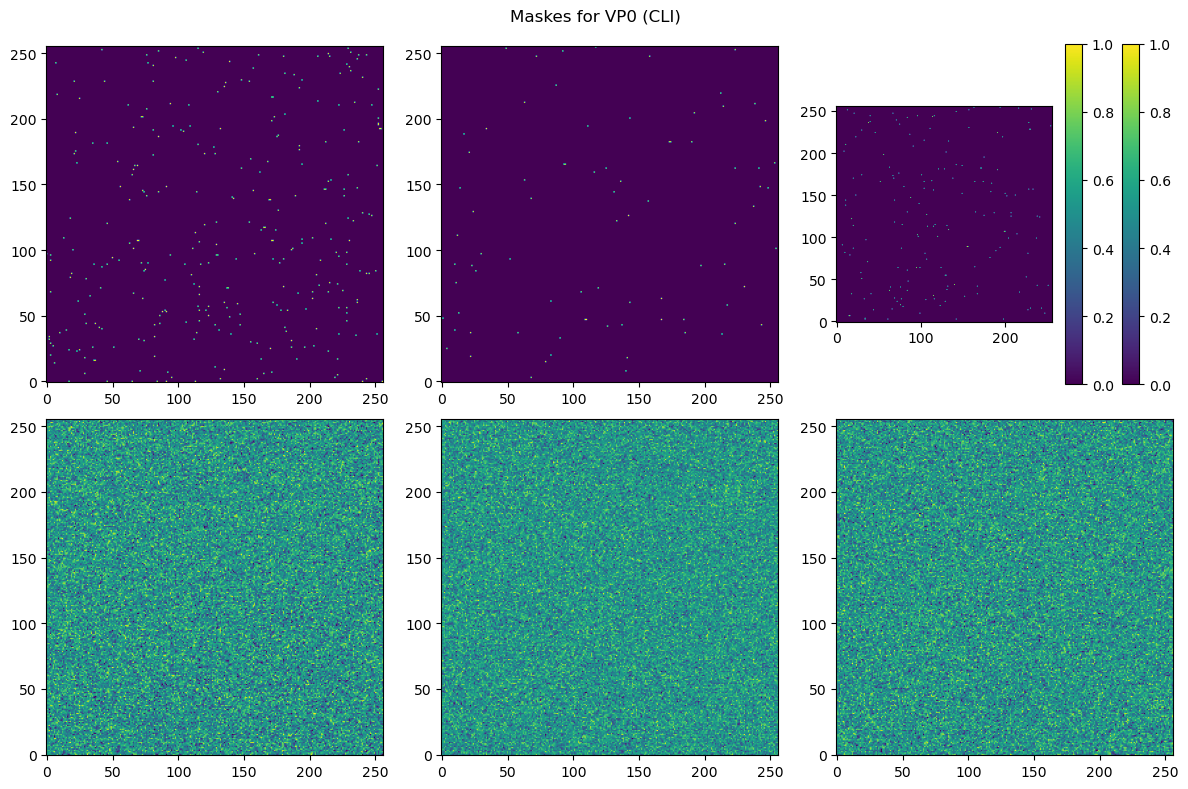

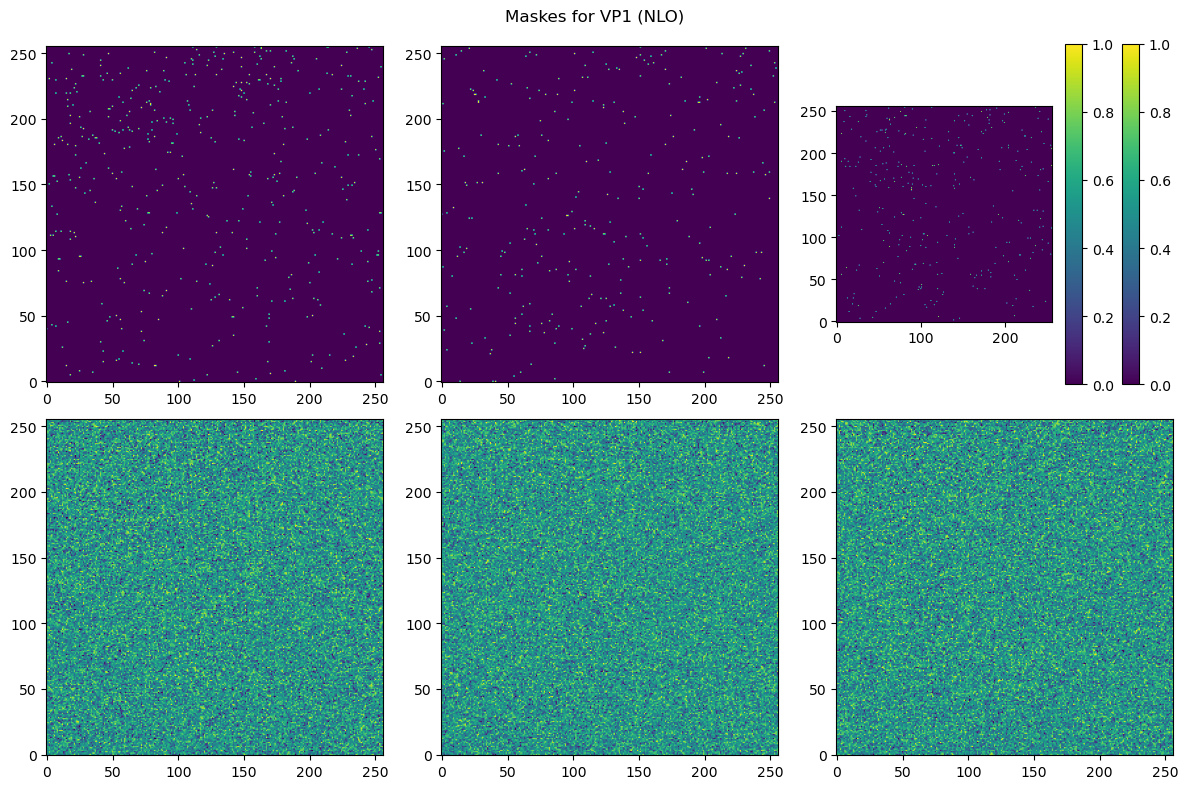

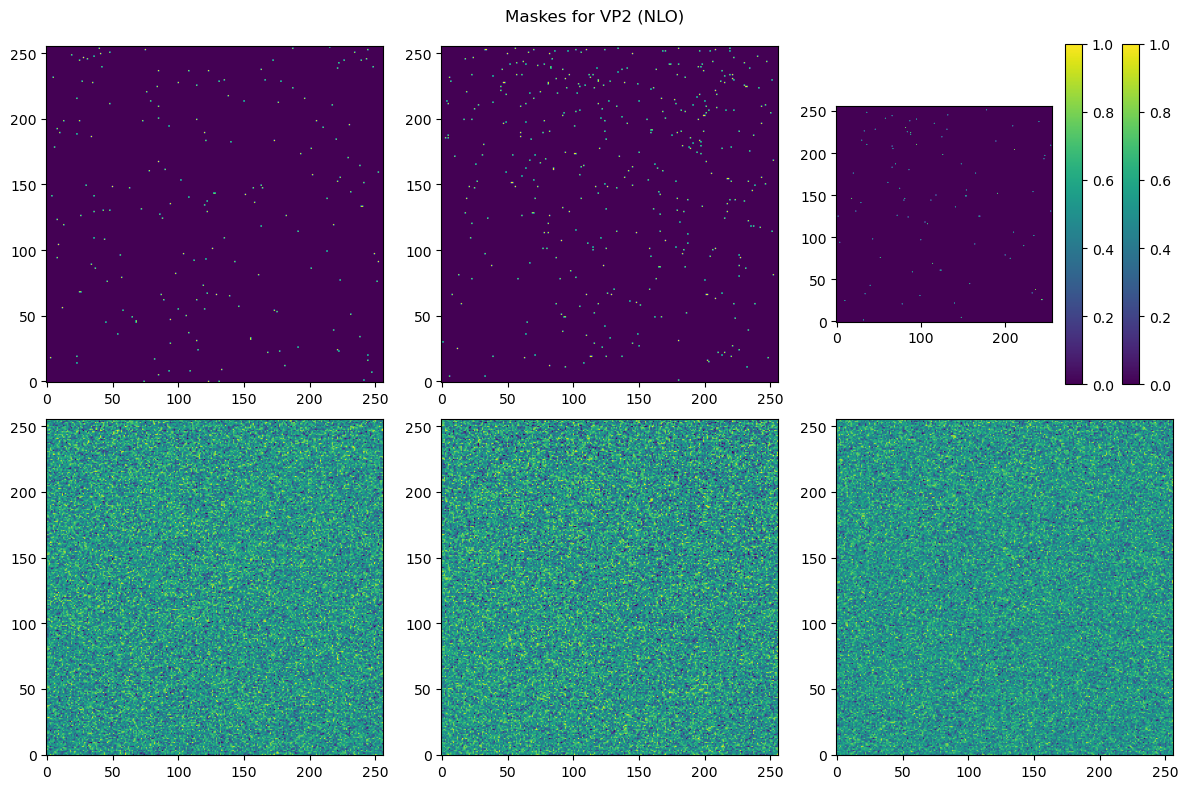

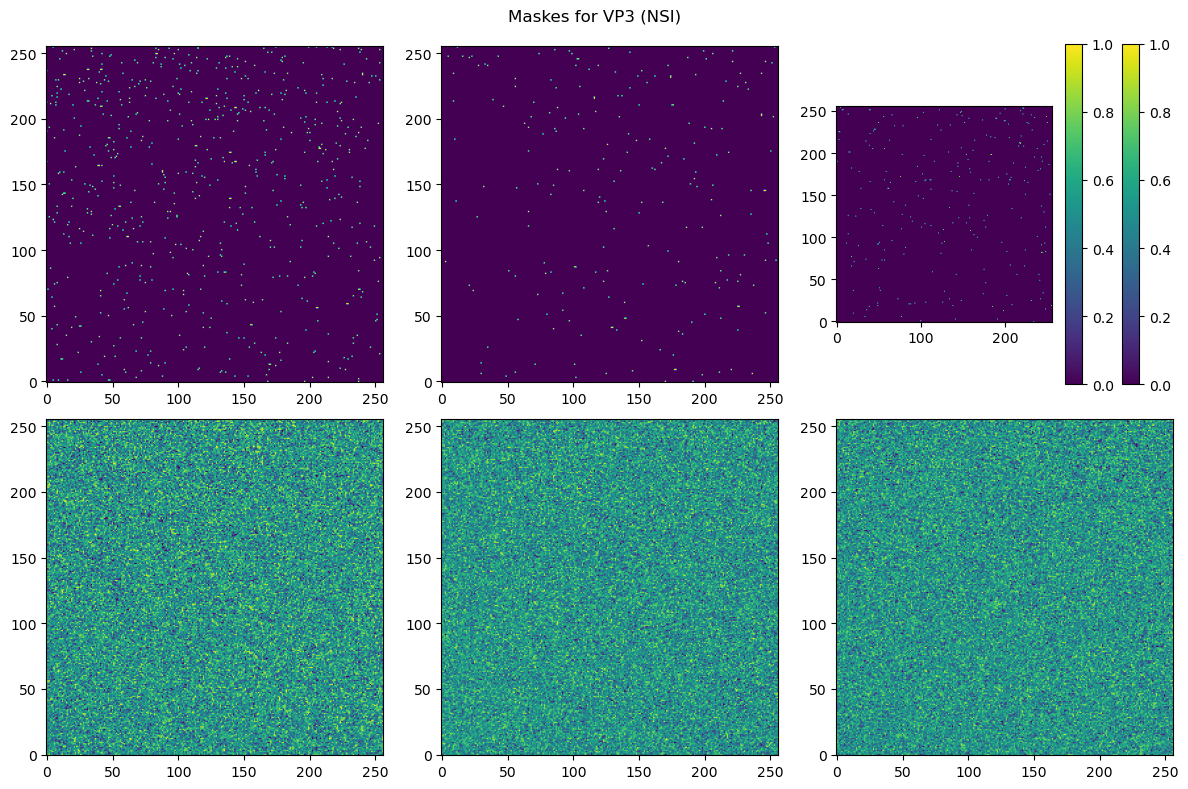

In [1]:
# Load the numpy libraries
import numpy as np
import tarfile
from matplotlib import pyplot as plt

# load data files

tgzFileName = "equalisation_M65_A15.tar.gz"
path = "100422_ColdTest"

fig, axT = plt.subplots(figsize=(6, 6))

def loadTGZ(tgz, fPath, dtype):
    """Load from the tarfile tgz a csv file with a path fPath, shape into 256*256 then cast to dtype"""
    with tgz.extractfile(fPath) as csv:
        return np.genfromtxt(csv,delimiter=",").reshape(256*256).astype(dtype)

def extractFromTGZ(tgzName, dSet):
    """Open tar.gz file tgzName and find csv files in dSet and return trim files"""
    path = dSet[0]+"/"
    outSet = {}
    with tarfile.open(tgzName,'r:gz') as tgz:
        outSet["tMean0"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Trim0_Noise_Mean.csv",np.float16)
        outSet["tMeanF"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_TrimF_Noise_Mean.csv",np.float16)
        outSet["tWidth0"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Trim0_Noise_Width.csv", np.float16)
        outSet["tWidthF"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_TrimF_Noise_Width.csv", np.float16)
        outSet["mask"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Matrix_Mask.csv", np.float16)
        outSet["trim"] = \
            loadTGZ(tgz,path + f"Module0_{dSet[1]}_Matrix_Trim.csv", np.int8)
    return outSet

vpList = [ [f"VP{i}-{j}" for j in range(3)] for i in range(4) ]
print(vpList)
oneSize = 256*256 # size of one input array
for i,vp3 in enumerate(vpList):
    fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2,3, figsize=(12,8))
    if i == 0 :
        plt.suptitle(f"Maskes for VP0 (CLI)")
    if i == 1 :
        plt.suptitle(f"Maskes for VP1 (NLO)")
    if i == 2 :
        plt.suptitle(f"Maskes for VP2 (NLO)")
    if i == 3 :
        plt.suptitle(f"Maskes for VP3 (NSI)")
    for j,vp in enumerate(vp3):
        if j == 0 : axT,axB = ax0,ax3
        if j == 1 : axT,axB = ax1,ax4
        if j == 2 : axT,axB = ax2,ax5
        outSet = extractFromTGZ(tgzFileName,(path,vp))
        _ = axT.imshow((outSet['mask']!=0).reshape(256,256), origin='lower') # convert back to square array
        _ = axB.imshow(outSet['trim'].reshape(256,256), origin='lower') # convert back to square array
    img = axT.imshow((outSet['mask']!=0).reshape(256,256), origin='lower')
    fig.colorbar(img, ax=axT)  # Now using the correct variable
    fig.colorbar(img, ax=ax2)
    plt.tight_layout()
    plt.show()
    


In [2]:
import numpy as np
import tarfile

def count_nan_pixels_one_vp(outSet):
    """Return a boolean mask and count of pixels that contain ANY NaN."""
    nan_mask = (
        np.isnan(outSet["tMean0"])
        | np.isnan(outSet["tMeanF"])
        | np.isnan(outSet["tWidth0"])
        | np.isnan(outSet["tWidthF"])
    )
    return nan_mask, int(nan_mask.sum())

def count_nan_pixels_module(tgzFile, module_path):
    """
    Loop over the 12 VPs (VP0‑0 … VP3‑2) for one module folder and
    count NaN‑contaminated pixels.
    """
    vp_labels = [f"VP{i}-{j}" for i in range(4) for j in range(3)]
    
    results = {}        # per‑VP counts
    total_nan = 0       # module‑level total
    
    for vp in vp_labels:
        outSet = extractFromTGZ(tgzFile, (module_path, vp))
        _, n_nan = count_nan_pixels_one_vp(outSet)
        results[vp] = n_nan
        total_nan += n_nan
    
    return total_nan, results

tgzFile   = "equalisation_M65_A15.tar.gz"
mod_path  = "100422_ColdTest"          # the sub‑folder you showed

total, per_vp = count_nan_pixels_module(tgzFile, mod_path)

print(f"Module '{mod_path}' – total NaN‑contaminated pixels: {total:,}")
for vp, cnt in per_vp.items():
    print(f"  {vp:5s} : {cnt:6d} pixels with a NaN")


Module '100422_ColdTest' – total NaN‑contaminated pixels: 3
  VP0-0 :      0 pixels with a NaN
  VP0-1 :      0 pixels with a NaN
  VP0-2 :      0 pixels with a NaN
  VP1-0 :      1 pixels with a NaN
  VP1-1 :      0 pixels with a NaN
  VP1-2 :      0 pixels with a NaN
  VP2-0 :      0 pixels with a NaN
  VP2-1 :      0 pixels with a NaN
  VP2-2 :      0 pixels with a NaN
  VP3-0 :      1 pixels with a NaN
  VP3-1 :      0 pixels with a NaN
  VP3-2 :      1 pixels with a NaN


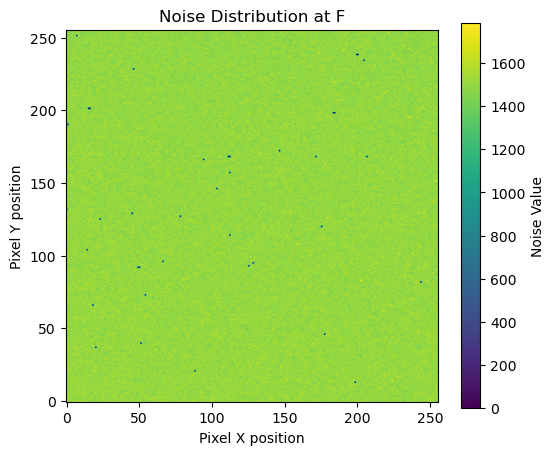

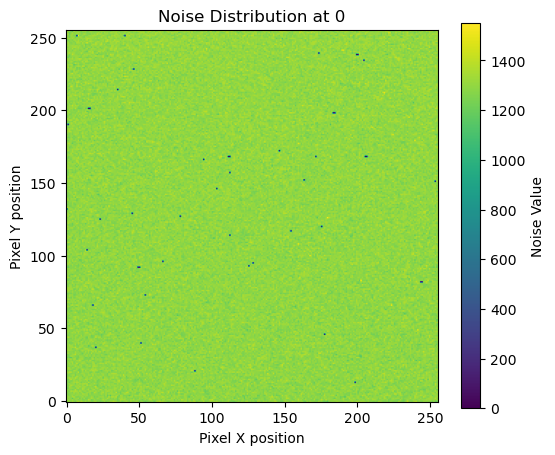

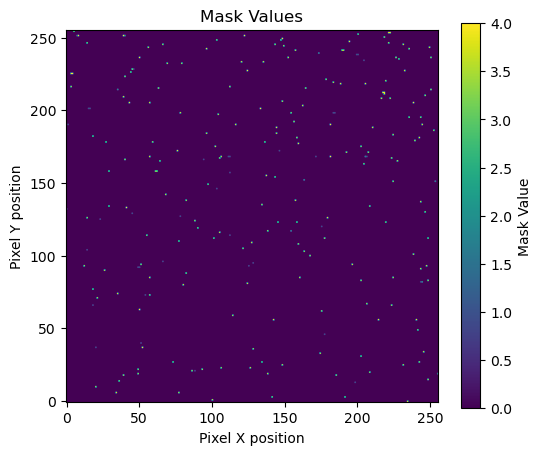

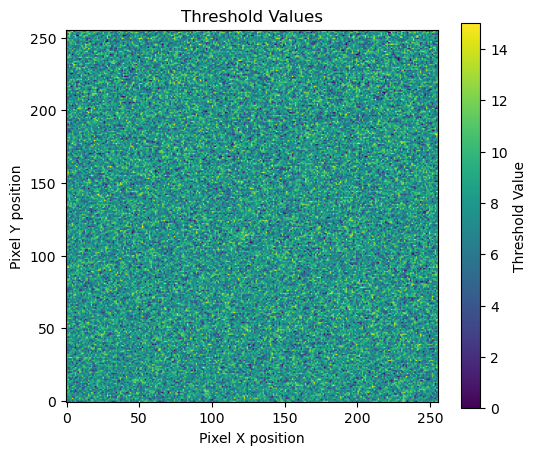

In [3]:
# Assuming you've extracted your data into outSet
threshold = outSet['trim'].reshape(256, 256)
noiseF = outSet['tMeanF'].reshape(256, 256)
noise0 = outSet['tMean0'].reshape(256, 256)
mask = outSet['mask'].reshape(256,256)

# Create coordinate grids for pixel positions
x_coords, y_coords = np.meshgrid(np.arange(256), np.arange(256))

plt.figure(figsize=(6,5))
plt.imshow(noiseF, origin='lower')
plt.title("Noise Distribution at F")
plt.colorbar(label="Noise Value")
plt.xlabel("Pixel X position")
plt.ylabel("Pixel Y position")
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(noise0, origin='lower')
plt.title("Noise Distribution at 0")
plt.colorbar(label="Noise Value")
plt.xlabel("Pixel X position")
plt.ylabel("Pixel Y position")
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(mask, origin='lower')
plt.title("Mask Values")
plt.colorbar(label="Mask Value")
plt.xlabel("Pixel X position")
plt.ylabel("Pixel Y position")
plt.show()

plt.figure(figsize=(6,5))
plt.imshow(threshold, origin='lower')
plt.title("Threshold Values")
plt.colorbar(label="Threshold Value")
plt.xlabel("Pixel X position")
plt.ylabel("Pixel Y position")
plt.show()


Average Pearson Correlation Matrix over all modules:
           threshold    noiseF    noise0    width0    widthF             x  \
threshold   1.000000 -0.722139 -0.780545  0.111583 -0.177308 -5.025708e-03   
noiseF     -0.722139  1.000000  0.871173 -0.025728  0.183119  2.065969e-02   
noise0     -0.780545  0.871173  1.000000 -0.040695  0.213740 -6.135700e-03   
width0      0.111583 -0.025728 -0.040695  1.000000  0.648198 -7.655154e-02   
widthF     -0.177308  0.183119  0.213740  0.648198  1.000000 -6.953906e-02   
x          -0.005026  0.020660 -0.006136 -0.076552 -0.069539  1.000000e+00   
y           0.001957 -0.054130  0.040225  0.159601  0.164399 -1.065662e-15   

                      y  
threshold  1.956716e-03  
noiseF    -5.413023e-02  
noise0     4.022544e-02  
width0     1.596013e-01  
widthF     1.643991e-01  
x         -1.065662e-15  
y          1.000000e+00  


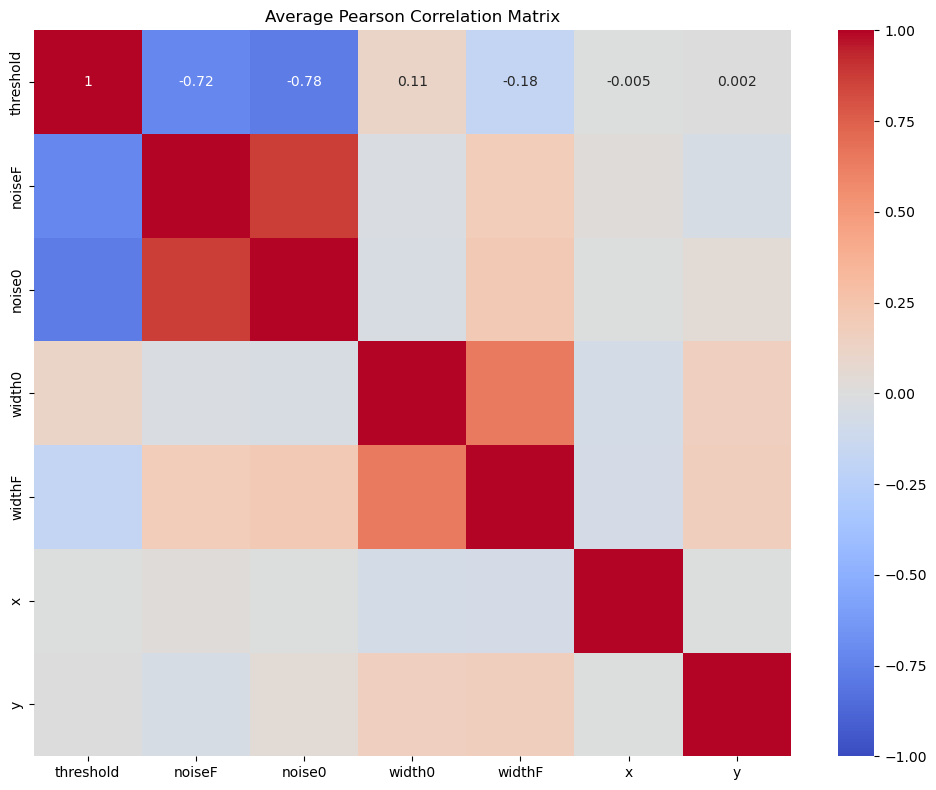

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the VP groups
vpList = [[f"VP{i}-{j}" for j in range(3)] for i in range(4)]
oneSize = 256 * 256  # Size of one input array

# Initialize accumulation variables for the correlation matrices and a module counter
sum_corr = None
module_count = 0

# Loop over each VP group and each module within the group
for group in vpList:
    for vp in group:
        # Extract the dataset for the current module
        outSet = extractFromTGZ(tgzFileName, (path, vp))
        
        # Reshape the flat arrays into 256x256 images
        threshold = outSet['trim'].reshape(256, 256)
        noiseF    = outSet['tMeanF'].reshape(256, 256)
        noise0    = outSet['tMean0'].reshape(256, 256)
        mask      = outSet['mask'].reshape(256, 256)
        width0    = outSet['tWidth0'].reshape(256, 256)
        widthF    = outSet['tWidthF'].reshape(256, 256)
        
        # Generate coordinate grids for pixel positions
        x_coords, y_coords = np.meshgrid(np.arange(256), np.arange(256))
        
        # Create a DataFrame where each row corresponds to a pixel
        data = {
            'threshold': threshold.ravel(),
            'noiseF':    noiseF.ravel(),
            'noise0':    noise0.ravel(),
            'width0':    width0.ravel(),
            'widthF':    widthF.ravel(),
            'x':         x_coords.ravel(),
            'y':         y_coords.ravel()
        }
        df = pd.DataFrame(data)
        
        # Calculate the Pearson correlation matrix for this module
        corr_matrix = df.corr(method='pearson')
        
        # Accumulate the correlation matrices
        if sum_corr is None:
            sum_corr = corr_matrix.copy()
        else:
            sum_corr += corr_matrix
        module_count += 1

# Compute the average correlation matrix over all modules
avg_corr = sum_corr / module_count

# Print the average correlation matrix
print("Average Pearson Correlation Matrix over all modules:")
print(avg_corr)

# Plot the average correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Average Pearson Correlation Matrix")
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd

# Use the averaged correlation matrix computed earlier:
# avg_corr is a DataFrame that includes the correlations of all columns over all modules.

# Extract the row corresponding to "threshold", dropping its self-correlation.
threshold_corr = avg_corr.loc['threshold'].drop('threshold')

# Convert the resulting Series into a one-row DataFrame.
threshold_corr_df = pd.DataFrame(threshold_corr).T

# Create a LaTeX table from this DataFrame.
latex_table = threshold_corr_df.to_latex(
    index=False,
    float_format="%.2f",
    caption="Average Pearson Correlation Coefficients for Global Coordinates and Input Features with Threshold",
    label="tab:global_corr",
    header=["noise0", "noiseF", "width0", "widthF", "x", "y"]
)

print(latex_table)


\begin{table}
\caption{Average Pearson Correlation Coefficients for Global Coordinates and Input Features with Threshold}
\label{tab:global_corr}
\begin{tabular}{rrrrrr}
\toprule
noise0 & noiseF & width0 & widthF & x & y \\
\midrule
-0.72 & -0.78 & 0.11 & -0.18 & -0.01 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}



Average Pearson Correlation Matrix over all modules (including local superpixel coordinates):
           threshold    noiseF    noise0      mask      global_x  \
threshold   1.000000 -0.722139 -0.780545 -0.178761 -5.025708e-03   
noiseF     -0.722139  1.000000  0.871173  0.014660  2.065969e-02   
noise0     -0.780545  0.871173  1.000000  0.028014 -6.135700e-03   
mask       -0.178761  0.014660  0.028014  1.000000 -5.866590e-04   
global_x   -0.005026  0.020660 -0.006136 -0.000587  1.000000e+00   
global_y    0.001957 -0.054130  0.040225  0.011740 -1.065662e-15   
local_x    -0.001597  0.003053 -0.000809  0.000003  1.512896e-02   
local_y     0.002450 -0.001842 -0.001263  0.000255  7.655408e-18   

               global_y       local_x       local_y  
threshold  1.956716e-03 -1.596849e-03  2.449513e-03  
noiseF    -5.413023e-02  3.052911e-03 -1.842180e-03  
noise0     4.022544e-02 -8.085681e-04 -1.262961e-03  
mask       1.174034e-02  2.660455e-06  2.554671e-04  
global_x  -1.065662e-15

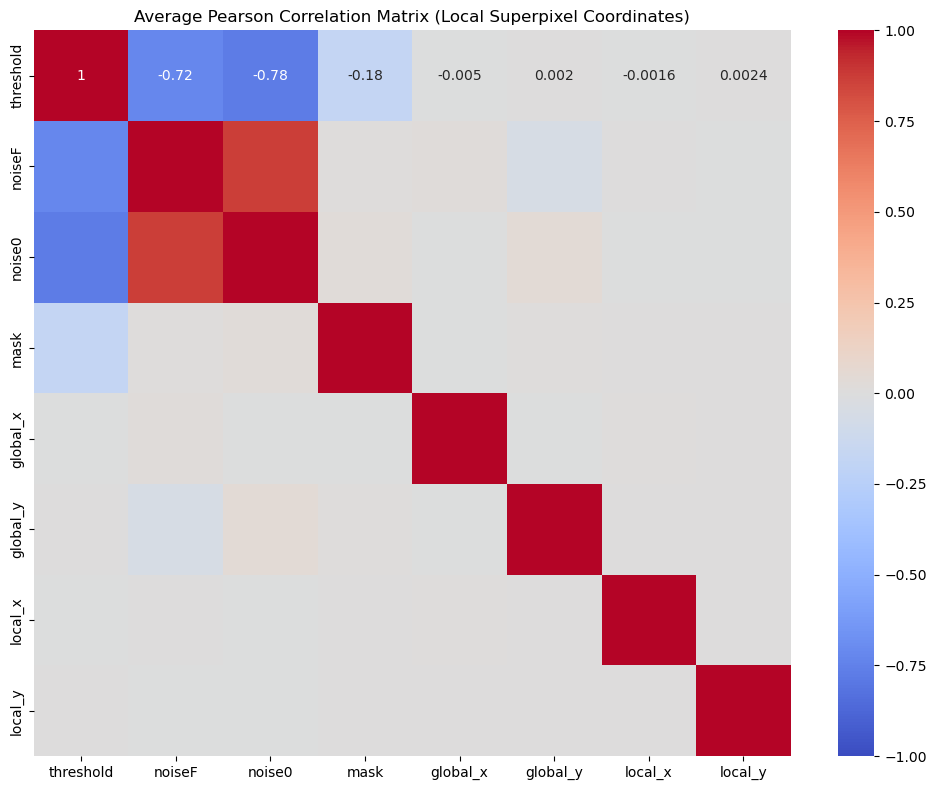

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the VP groups (each group contains 3 modules)
vpList = [[f"VP{i}-{j}" for j in range(3)] for i in range(4)]
oneSize = 256 * 256  # Total number of pixels per module

# Initialize accumulation variables for the correlation matrices and a module counter
sum_corr = None
module_count = 0

# Loop over each VP module
for group in vpList:
    for vp in group:
        # Extract the dataset for the current module
        outSet = extractFromTGZ(tgzFileName, (path, vp))
        
        # Reshape the flat arrays into 256x256 images
        threshold = outSet['trim'].reshape(256, 256)
        noiseF    = outSet['tMeanF'].reshape(256, 256)
        noise0    = outSet['tMean0'].reshape(256, 256)
        mask      = outSet['mask'].reshape(256, 256)
        
        # Create global coordinate grids (using np.indices: rows = y, columns = x)
        global_y, global_x = np.indices((256, 256))
        
        # Compute local coordinates within each superpixel.
        # For a 2x4 superpixel, the local y-coordinate is given by row % 2 and local x by col % 4.
        local_y = global_y % 2
        local_x = global_x % 4
        
        # Build a DataFrame where each row corresponds to a pixel
        data = {
            'threshold': threshold.ravel(),
            'noiseF':    noiseF.ravel(),
            'noise0':    noise0.ravel(),
            'mask':      mask.ravel(),
            'global_x':   global_x.ravel(),  # local position within the superpixel along x (0 to 3)
            'global_y':   global_y.ravel(),
            'local_x':   local_x.ravel(),  # local position within the superpixel along x (0 to 3)
            'local_y':   local_y.ravel()   # local position within the superpixel along y (0 or 1)
        }
        df = pd.DataFrame(data)
        
        # Compute the Pearson correlation matrix for the current module
        corr_matrix = df.corr(method='pearson')
        
        # Accumulate the correlation matrices
        if sum_corr is None:
            sum_corr = corr_matrix.copy()
        else:
            sum_corr += corr_matrix
        module_count += 1

# Compute the average correlation matrix over all modules
avg_corr = sum_corr / module_count

# Print the average correlation matrix
print("Average Pearson Correlation Matrix over all modules (including local superpixel coordinates):")
print(avg_corr)

# Plot the average correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(avg_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Average Pearson Correlation Matrix (Local Superpixel Coordinates)")
plt.tight_layout()
plt.show()


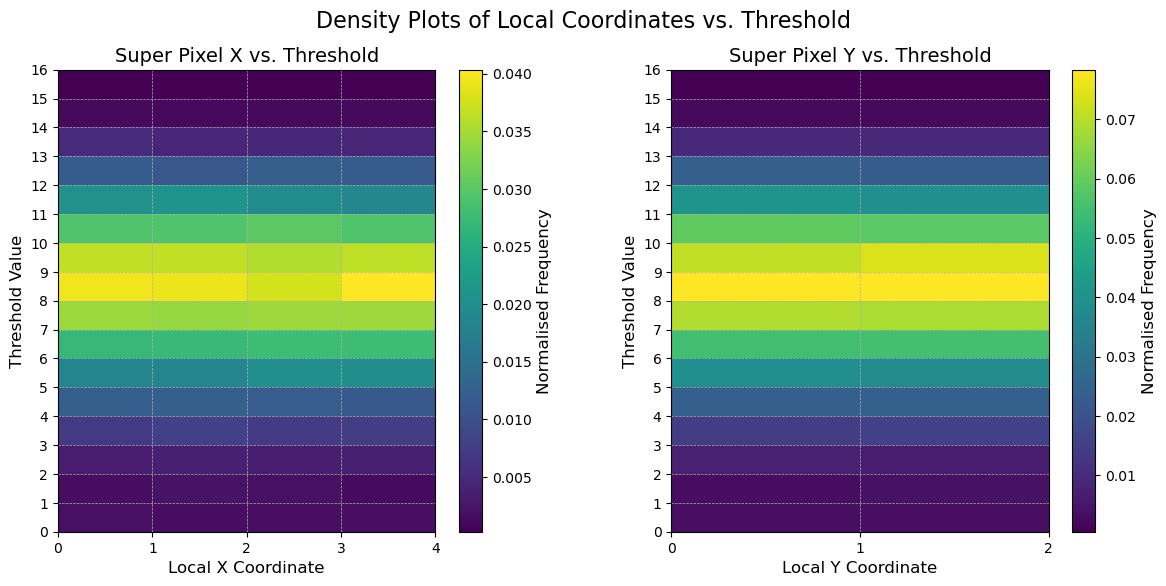

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Define bin edges so that each bin corresponds to an integer interval.
# For local_x (values assumed to be in {0,1,2,3}), we define edges 0 to 4.
bins_x = np.arange(0, 5, 1)        # Edges: [0,1,2,3,4]
# For threshold (values assumed to be integers from 0 to 16), define edges 0 to 17.
bins_th = np.arange(0, 17, 1)        # Edges: [0,1,...,16,17]
# For local_y (values assumed to be in {0,1}), define edges 0 to 2.
bins_y = np.arange(0, 3, 1)          # Edges: [0,1,2]

# Create a figure with 1 row and 2 columns.
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Adjust horizontal spacing between subplots.
plt.subplots_adjust(wspace=0.3)

# Plot 1: Local X vs. Threshold
im1 = axes[0].hist2d(
    df['local_x'], 
    df['threshold'], 
    bins=[bins_x, bins_th],
    density=True,
    cmap='viridis',
    norm=Normalize()
)
axes[0].set_xlabel("Local X Coordinate", fontsize=12)
axes[0].set_ylabel("Threshold Value", fontsize=12)
axes[0].set_title("Super Pixel X vs. Threshold", fontsize=14)
axes[0].set_xticks(np.arange(0, 5, 1))
axes[0].set_yticks(np.arange(0, 17, 1))
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
cbar1 = fig.colorbar(im1[3], ax=axes[0])
cbar1.set_label("Normalised Frequency", fontsize=12)

# Plot 2: Local Y vs. Threshold
im2 = axes[1].hist2d(
    df['local_y'], 
    df['threshold'], 
    bins=[bins_y, bins_th],
    density=True,
    cmap='viridis',
    norm=Normalize()
)
axes[1].set_xlabel("Local Y Coordinate", fontsize=12)
axes[1].set_ylabel("Threshold Value", fontsize=12)
axes[1].set_title("Super Pixel Y vs. Threshold", fontsize=14)
axes[1].set_xticks(np.arange(0, 3, 1))
axes[1].set_yticks(np.arange(0, 17, 1))
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
cbar2 = fig.colorbar(im2[3], ax=axes[1])
cbar2.set_label("Normalised Frequency", fontsize=12)

fig.suptitle("Density Plots of Local Coordinates vs. Threshold", fontsize=16)
plt.show()
